Template matching based on PCA

In [1]:
# Library imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os
import napari

from image_utils import *
from template_matching import *

dicom_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23_Segmentation.nii")

Load segmentation

The shape of the image is (100, 672, 672)


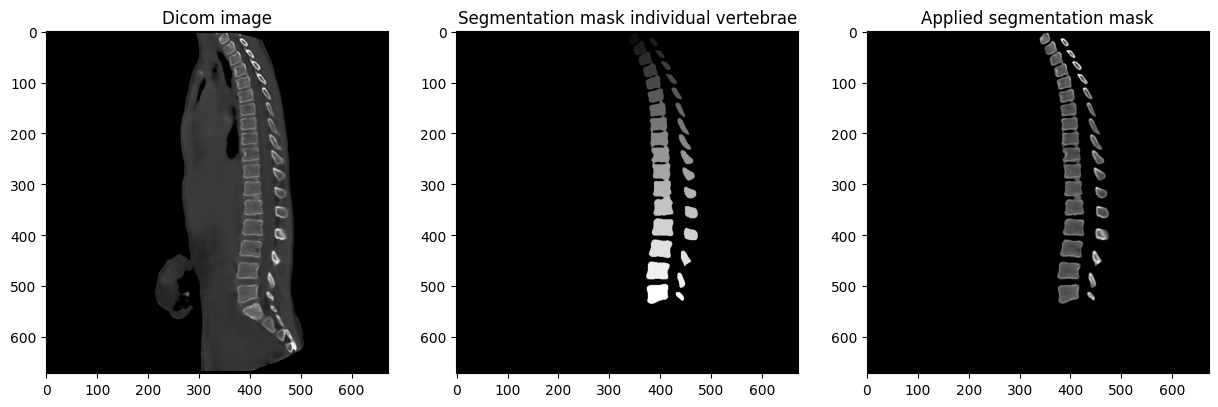

In [2]:
# Load segmentation data
segment = sitk.ReadImage(segmentation_path)
segment_data = sitk.GetArrayFromImage(segment)
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(dicom_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, ...], cmap='gray')
ax[0].set_title("Dicom image")
ax[1].imshow(segment_data[slice_index, ...], cmap='gray')
ax[1].set_title("Segmentation mask individual vertebrae")
ax[2].imshow(segment_dicom_image[slice_index, ...], cmap='gray')
ax[2].set_title("Applied segmentation mask");

Get the euler angles

In [3]:
bounding_box_coords, bounding_box_masks, euler_angles = get_euler_angles(segment_data)
print(f"The euler angles are {euler_angles}")

Computed bounding box for 17 vertebra
The euler angles are {1: array([ 17.04008076,  -1.13132116, -18.80108004]), 2: array([37.54078145, -2.12110716,  3.15390246]), 3: array([-44.16047077,   0.1660897 ,  -4.31281637]), 4: array([-35.76600993,   5.86668006,  -5.28001901]), 5: array([-29.11950045,   8.0691922 ,  -2.68710898]), 6: array([-25.65469923,   8.65973325,  -2.96024963]), 7: array([-22.37764829, -23.74312982,   0.63932436]), 8: array([-20.33724177,  35.73169644,   1.11953179]), 9: array([-18.30973579,  29.08555753,   1.79104721]), 10: array([44.22017369,  1.93695345, 24.60189757]), 11: array([-20.69996705, -39.91147781,  -2.40340045]), 12: array([-0.94409092,  4.52703879,  0.54039844]), 13: array([-1.12556531, -3.71243272, -1.76895443]), 14: array([  3.94875842, -25.06837637,  -2.88237979]), 15: array([  6.50584096, -13.59221246,  -0.88207798]), 16: array([  6.08181015, -11.52690967,  -1.01335645]), 17: array([ 2.21441673, -1.21352279,  2.43995732])}


Make the templates for matching

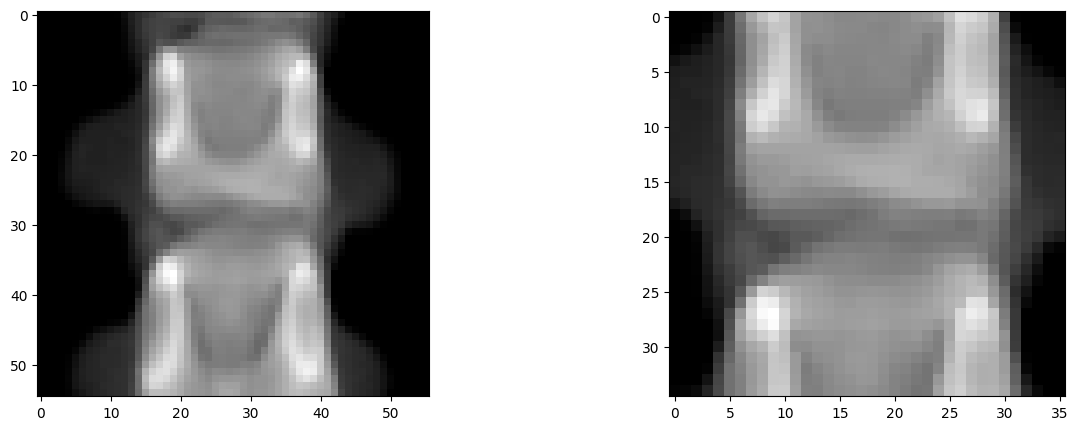

In [4]:
label = 9
template = generate_template(segment_dicom_image, segment_data, label, euler_angles, plot=True)

Generate 3D input ROI

In [5]:
ROI_3D_image, ref_3D_image, rotated_image, rotated_mask = make_input_3D_ROI(segment_dicom_image, segment_data, label, euler_angles, saggital_angle=0, coronal_angle=0, axial_angle=0)    

The updated euler angles after initial rotation are:  [-18.30973579  29.08555753   1.79104721]


Use template matching and plot the results

Best Angles: Saggital=-18.49572643244509 degrees, Coronal=0.0 degrees, Axial=2.003232612210949 degrees


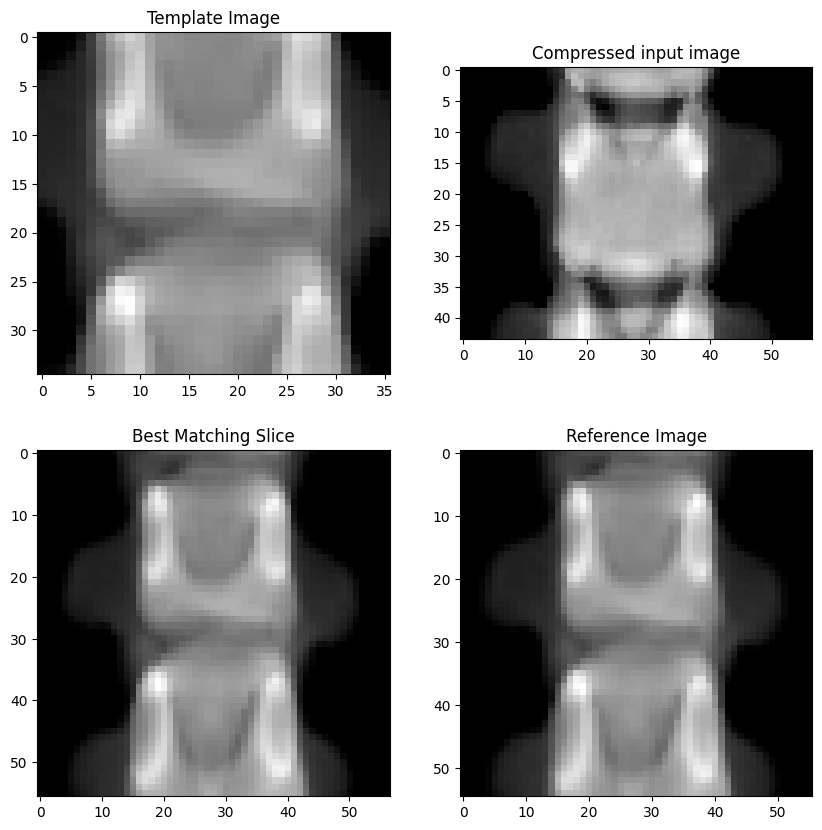

In [6]:
# Optimization using SciPy
bounds = [(-45, 45), (0, 0), (-15, 15)]  # Bounds the saggital, coronal, and axial angles

# Optimize the rotation angles
optimal_angles = optimize_rotation(ROI_3D_image, template, bounds)

print(f"Best Angles: Saggital={optimal_angles[0]} degrees, Coronal={optimal_angles[1]} degrees, Axial={optimal_angles[2]} degrees")

# Compress the 3D image along the z-axis
input_2d_image = compress_bonemri(ROI_3D_image, axis=2).astype(np.float32)
ref_2D_image = compress_bonemri(ref_3D_image, axis=2).astype(np.float32)

# Visualize the best matching slice
best_rotated = rotate_3D(rotated_image, sagittal_angle=optimal_angles[0], axial_angle=optimal_angles[2])
best_rotated_mask = rotate_3D(rotated_mask, sagittal_angle=optimal_angles[0], axial_angle=optimal_angles[2])
# Obtain individual segmented vertebra bbox image
best_rot_bbox_coord, best_rot_bbox_mask = compute_bbox(best_rotated_mask)
best_3D_image = best_rotated[
    best_rot_bbox_coord["z_min"]-5:best_rot_bbox_coord["z_max"]+5,
    best_rot_bbox_coord["y_min"]:best_rot_bbox_coord["y_max"],
    best_rot_bbox_coord["x_min"]:best_rot_bbox_coord["x_max"],
]

best_slice = compress_bonemri(best_3D_image, axis=2)

figure, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(np.rot90(template,3), cmap='gray')
ax[0,0].set_title("Template Image")

ax[0,1].imshow(np.rot90(input_2d_image,3), cmap='gray')
ax[0,1].set_title("Compressed input image")

ax[1,0].imshow(np.rot90(best_slice,3), cmap='gray')
ax[1,0].set_title("Best Matching Slice")

ax[1,1].imshow(np.rot90(ref_2D_image,3), cmap='gray')
ax[1,1].set_title("Reference Image")
plt.show()